In [1]:
## import libraries

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [3]:
## data transforms ::: BASIC and NEEDED

train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


In [4]:
## download dataset

train = datasets.MNIST("./data", train=True, download=True, transform=train_transforms)
test = datasets.MNIST("./data", train=False, download=True, transform=test_transforms)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 46766513.66it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1167089.24it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 10628909.67it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3485915.60it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
## DataLoader setters
SEED = 1

device = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(SEED)

if device == "cuda":
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if device=="cuda" else dict(shuffle=True, batch_size=64)

print(f"dataloader args: {dataloader_args}")

train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)
len(train_loader), len(test_loader)

dataloader args: {'shuffle': True, 'batch_size': 128, 'num_workers': 4, 'pin_memory': True}


(469, 79)

/opt/conda/lib/python3.10/site-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
- Numpy Shape:  (60000, 28, 28)
- Tensor Shape:  torch.Size([60000, 28, 28])
- Min:  tensor(-0.4242)
- Max:  tensor(2.8215)
- Mean:  tensor(-0.0001)
- Std:  tensor(1.0000)
- Var:  tensor(1.0001)
Shape of images:  torch.Size([128, 1, 28, 28])
Shape of labels:  torch.Size([128])


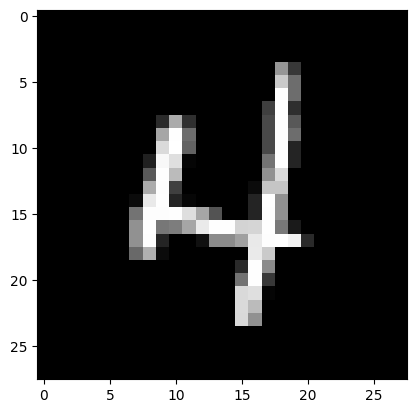

In [6]:
## Data statistics
import matplotlib.pyplot as plt

train_data = train.train_data
train_data = train.transform(train_data.numpy())

print(f"[Train]")
print("- Numpy Shape: ", train.train_data.cpu().numpy().shape)
print("- Tensor Shape: ", train.train_data.size())
print("- Min: ", torch.min(train_data))
print("- Max: ", torch.max(train_data))
print("- Mean: ", torch.mean(train_data))
print("- Std: ", torch.std(train_data))
print("- Var: ", torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print("Shape of images: ", images.shape)
print("Shape of labels: ", labels.shape)

plt.imshow(images[0].numpy().squeeze(), cmap='gray')

/tmp/ipykernel_23/1386968507.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(8, 10, idx)


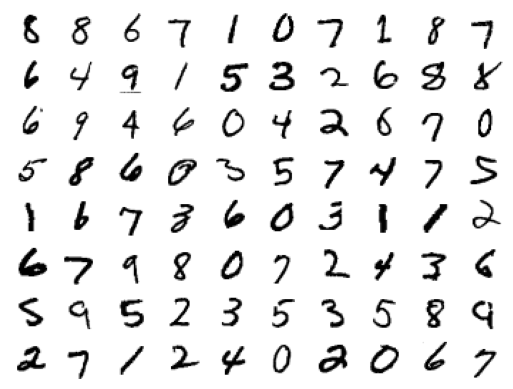

In [13]:
## Visualize Images

fig = plt.figure()
plt.title('Display')
num_images = 80

for idx in range(1, num_images+1):
    plt.subplot(8, 10, idx)
    plt.axis('off')
    # plt.title('num')
    plt.imshow(images[idx].numpy().squeeze(), cmap='gray_r')

In [15]:
### Get mean & std values

simple_transforms = transforms.Compose([
    transforms.ToTensor()
])

exp = datasets.MNIST("./data", train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print("[TRAIN]")
print("- Numpy Shape: ", exp.train_data.cpu().numpy().shape)
print("- Tensor Shape: ", exp.train_data.size())
print("- Min: ", torch.min(exp_data))
print("- Max: ", torch.max(exp_data))
print(" -Mean: ", torch.mean(exp_data))
print("- Std: ", torch.std(exp_data))
print("- Var: ", torch.var(exp_data))

[TRAIN]
- Numpy Shape:  (60000, 28, 28)
- Tensor Shape:  torch.Size([60000, 28, 28])
- Min:  tensor(0.)
- Max:  tensor(1.)
 -Mean:  tensor(0.1307)
- Std:  tensor(0.3081)
- Var:  tensor(0.0949)


In [17]:
## Model Architecture

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        """
        n_out = (28-3 + 2)/1 + 1 = 28
        J_out = 1*1 = 1
        Rf_out = 1 + (3-1)*1 = 3
        """
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        """
        n_out = (28-3+2)/1 + 1 = 26
        J_out = 1*1 = 1 
        Rf_out = 3 + (3-1)*1 = 5
        """
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        """
        n_out = (26-3)/1 + 1 = 24
        J_out = 1*1 = 1
        Rf_out = 5 + (3-1)*1 = 7
        """
        self.max_pool1 = nn.MaxPool2d((2,2))
        """
        n_out = ((24-2)/2) + 1 = 12
        J_out = 1*2 = 2
        Rf_out = 7 + (2-1)*2 = 9
        """
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        """
        n_out = (12-3+2)/1 + 1 = 12
        J_out = 2
        Rf_out = 9 + (3-1)*2 = 13
        """
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512,  kernel_size=3)
        """
        n_out = (12-3)/1 + 1 = 10
        J_out = 2
        Rf_out = 13 + (3-1)*2 = 17
        """
        self.max_pool2 = nn.MaxPool2d((2, 2))
        """
        n_out = (10-3+2)/2 + 1 = 5
        J_out = 2*2 = 4
        Rf_out = 17 + (2-1)*4 = 21
        """
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        """
        n_out = (5-3+2) + 1 = 5
        J_out = 4*1 = 4
        Rf_out = 21 + (3-1)*4 = 29
        """
        self.conv7 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3)
        """
        n_out = (5-3) * 1 = 3
        J_out = 4*1 = 4
        Rf_out = 29 + (3-1)*4 = 37
        """
        self.conv8 = nn.Conv2d(in_channels=256, out_channels=10, kernel_size=3)
        """
        n_out = (3-3) + 1 = 1
        J_out = 4*1 = 4
        Rf_out = 37 + (3-1)*4 = 45
        """

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.max_pool1(x)
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.max_pool2(x)
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = self.conv8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device alloted: ", device)
model = Net().to(device)

Device alloted:  cuda


In [18]:
!pip install torchsummary

In [19]:
from torchsummary import summary
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 26, 26]          18,496
            Conv2d-3          [-1, 128, 24, 24]          73,856
         MaxPool2d-4          [-1, 128, 12, 12]               0
            Conv2d-5          [-1, 256, 12, 12]         295,168
            Conv2d-6          [-1, 512, 10, 10]       1,180,160
         MaxPool2d-7            [-1, 512, 5, 5]               0
            Conv2d-8            [-1, 512, 5, 5]       2,359,808
            Conv2d-9            [-1, 256, 3, 3]       1,179,904
           Conv2d-10             [-1, 10, 1, 1]          23,050
Total params: 5,130,762
Trainable params: 5,130,762
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 2.11
Params size (MB): 19.57
Estima

In [20]:
## Train & Test

from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get data
        data, target = data.to(device), target.to(device)
        # zero the gradients
        optimizer.zero_grad()
        # Get the predictions
        y_pred = model(data)
        # calc loss
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)
        # Backpropagation
        loss.backward()
        #upgrade weights
        optimizer.step()

        pred = y_pred.argmax(dim=1, keepdim=True) # get index of max log probablity
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc=f"Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}")
        train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    # initialize the no gradients such that no weights get updated/DOnt calc gradients in the loop
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [21]:
model1 = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20 
for epoch in range(EPOCHS):
    print(f"[EPOCH]: {epoch}")
    train(model, device, train_loader, optimizer, epoch)
    test(model ,device, test_loader)

[EPOCH]: 0


Loss=0.033753588795661926 Batch_id=468 Accuracy=77.31: 100%|██████████| 469/469 [00:24<00:00, 18.99it/s]



Test set: Average loss: 0.0693, Accuracy: 9779/10000 (97.79%)

[EPOCH]: 1


Loss=0.04844551160931587 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:23<00:00, 19.61it/s]  



Test set: Average loss: 0.0383, Accuracy: 9873/10000 (98.73%)

[EPOCH]: 2


Loss=0.01667308434844017 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:22<00:00, 20.66it/s]  



Test set: Average loss: 0.0343, Accuracy: 9892/10000 (98.92%)

[EPOCH]: 3


Loss=0.006173842120915651 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:23<00:00, 20.13it/s] 



Test set: Average loss: 0.0268, Accuracy: 9912/10000 (99.12%)

[EPOCH]: 4


Loss=0.0084752282127738 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:23<00:00, 19.81it/s]   



Test set: Average loss: 0.0264, Accuracy: 9910/10000 (99.10%)

[EPOCH]: 5


Loss=0.002907750429585576 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:23<00:00, 20.16it/s] 



Test set: Average loss: 0.0291, Accuracy: 9911/10000 (99.11%)

[EPOCH]: 6


Loss=0.019069217145442963 Batch_id=468 Accuracy=99.52: 100%|██████████| 469/469 [00:23<00:00, 20.20it/s]  



Test set: Average loss: 0.0252, Accuracy: 9918/10000 (99.18%)

[EPOCH]: 7


Loss=0.0021416458766907454 Batch_id=468 Accuracy=99.64: 100%|██████████| 469/469 [00:23<00:00, 20.08it/s] 



Test set: Average loss: 0.0321, Accuracy: 9917/10000 (99.17%)

[EPOCH]: 8


Loss=0.0008540772250853479 Batch_id=468 Accuracy=99.69: 100%|██████████| 469/469 [00:23<00:00, 20.06it/s] 



Test set: Average loss: 0.0260, Accuracy: 9922/10000 (99.22%)

[EPOCH]: 9


Loss=0.009947496466338634 Batch_id=468 Accuracy=99.78: 100%|██████████| 469/469 [00:23<00:00, 20.05it/s]  



Test set: Average loss: 0.0230, Accuracy: 9929/10000 (99.29%)

[EPOCH]: 10


Loss=0.00045794143807142973 Batch_id=468 Accuracy=99.79: 100%|██████████| 469/469 [00:23<00:00, 20.04it/s]



Test set: Average loss: 0.0327, Accuracy: 9922/10000 (99.22%)

[EPOCH]: 11


Loss=0.0060049728490412235 Batch_id=468 Accuracy=99.80: 100%|██████████| 469/469 [00:23<00:00, 19.99it/s] 



Test set: Average loss: 0.0266, Accuracy: 9929/10000 (99.29%)

[EPOCH]: 12


Loss=0.007088827434927225 Batch_id=468 Accuracy=99.82: 100%|██████████| 469/469 [00:23<00:00, 20.03it/s]  



Test set: Average loss: 0.0267, Accuracy: 9930/10000 (99.30%)

[EPOCH]: 13


Loss=0.033948544412851334 Batch_id=468 Accuracy=99.92: 100%|██████████| 469/469 [00:23<00:00, 20.09it/s]  



Test set: Average loss: 0.0415, Accuracy: 9910/10000 (99.10%)

[EPOCH]: 14


Loss=0.0019618922378867865 Batch_id=468 Accuracy=99.92: 100%|██████████| 469/469 [00:23<00:00, 20.00it/s] 



Test set: Average loss: 0.0278, Accuracy: 9930/10000 (99.30%)

[EPOCH]: 15


Loss=0.0003431325312703848 Batch_id=468 Accuracy=99.94: 100%|██████████| 469/469 [00:23<00:00, 19.91it/s] 



Test set: Average loss: 0.0307, Accuracy: 9937/10000 (99.37%)

[EPOCH]: 16


Loss=0.03066195547580719 Batch_id=468 Accuracy=99.88: 100%|██████████| 469/469 [00:23<00:00, 19.96it/s]   



Test set: Average loss: 0.0368, Accuracy: 9914/10000 (99.14%)

[EPOCH]: 17


Loss=2.2203179469215684e-05 Batch_id=468 Accuracy=99.91: 100%|██████████| 469/469 [00:23<00:00, 19.98it/s]



Test set: Average loss: 0.0292, Accuracy: 9936/10000 (99.36%)

[EPOCH]: 18


Loss=1.6183626939891838e-05 Batch_id=468 Accuracy=99.97: 100%|██████████| 469/469 [00:23<00:00, 20.00it/s]



Test set: Average loss: 0.0280, Accuracy: 9936/10000 (99.36%)

[EPOCH]: 19


Loss=3.449968426139094e-05 Batch_id=468 Accuracy=99.96: 100%|██████████| 469/469 [00:23<00:00, 19.95it/s] 



Test set: Average loss: 0.0337, Accuracy: 9932/10000 (99.32%)



Text(0.5, 1.0, 'Test Accuracy')

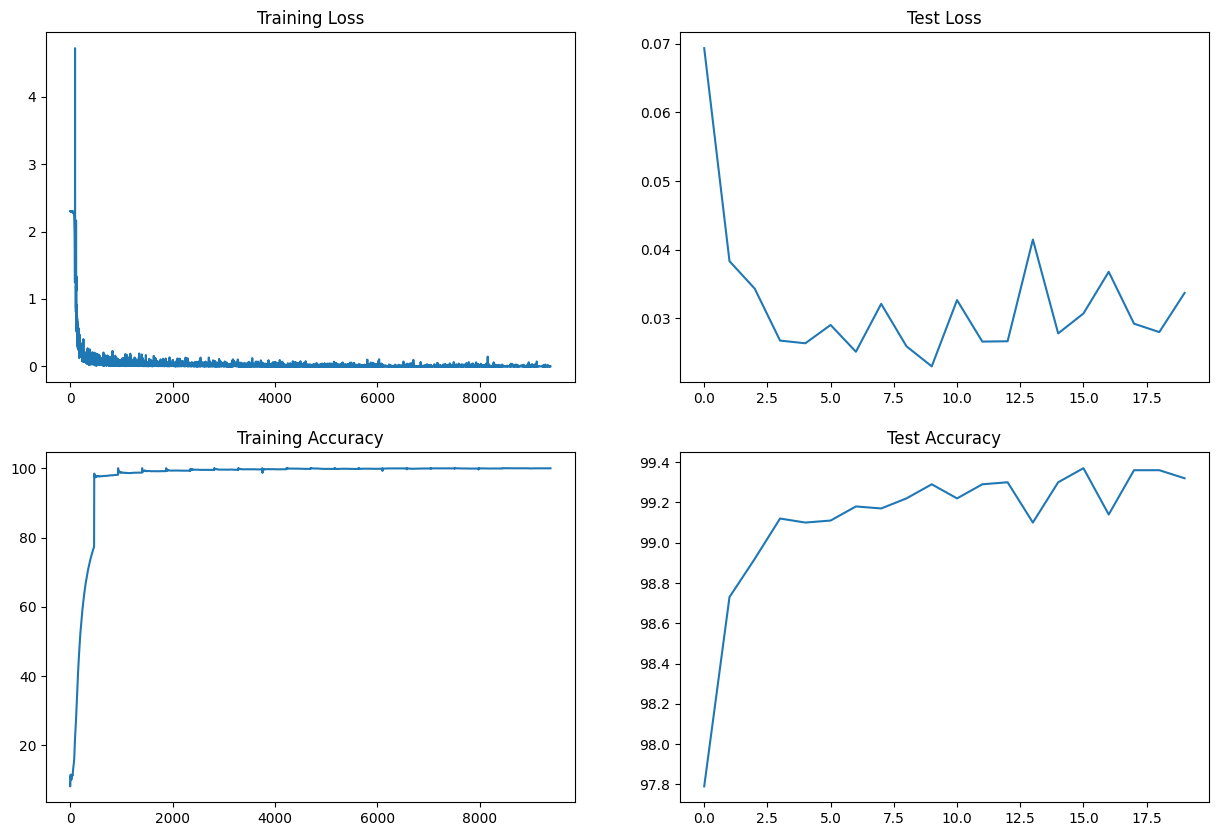

In [22]:
t = [t_items.item() for t_items in train_losses]

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

**Target**:
----------

    1. Setup
    
    2. Basic necessary transforms of ToTensor(), Normalize
    
    3. Stored via Dataloader
    
    4. Huge Parameters Neural Network
    
    5. Basic Training & Testing Loops
    
    6. Train for 20 Epochs & Visualize logs


**Result**:
----------
    A. Parameters: 5.13M (5,130,762)
    
    B. Best Training Accuracy: 99.97 (18th EPOCH)
    
    C. Best Test Accuracy: 99.37 (15th EPOCH)


**Analysis**:
-------------
    A. Extremely Heavy Model for such a problem (MNIST, as its image size is of only 28*28, we have to reduce network architectures)
    
    B. A bit of overfitting lies


In [23]:
print("FIRST ITERATION OF BASIC SETUP IS DONE")

FIRST ITERATION OF BASIC SETUP IS DONE
